# Importing Libraries

In [2]:
import pytesseract
from PIL import Image
import cv2
import math
import cvzone
import torch
import matplotlib.pyplot as plt
from sort import *
import easyocr

In [11]:
torch.cuda.is_available()

True

# PyTesseart

In [24]:
def img_to_string(image):
    pytesseract.pytesseract.tesseract_cmd = r"E:\Tesseract\tesseract.exe"
    img = cv2.imread(image)
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(img_grey)
    return text

image_path = 'Number plate.jpg'
results = img_to_string(image_path)

if results:
    print(f'Extracted text: {results}')
else:
    print('Nothing :)')

Extracted text: 24 BH 0001 AA |

Le



# Function for video to extract OCR

In [25]:
def img_to_text(frame, x1,y1,x2,y2):
    pytesseract.pytesseract.tesseract_cmd = r"E:\Tesseract\tesseract.exe"
    crop = frame[y1:y2, x1:x2]
    crop_gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    cv2.imwrite('ouput.jpg', crop)
    text = pytesseract.image_to_string(crop)
    alphanumeric_text = ''.join(filter(str.isalnum, text))
    #print(alphanumeric_text)
    return alphanumeric_text
        

# YOLO model

In [4]:
from ultralytics import YOLO

In [6]:
classNames = ['number plate', 'gas', 'bike','dragon']

In [5]:
model = YOLO('Anpr.pt')

In [7]:
def ANPR_new(frame, x1, y1, x2, y2):
    # Crop the region of interest (ROI) from the frame based on the provided coordinates
    roi = frame[y1:y2, x1:x2]

    # Initialize EasyOCR reader with the desired language(s)
    reader = easyocr.Reader(['en'])

    # Perform text recognition on the ROI
    results = reader.readtext(roi)

    detected_text = ""  # Initialize a variable to store the detected text

    for (bbox, text, prob) in results:
        detected_text += text + " "  # Concatenate the detected text

    return detected_text


0: 160x640 1 number plate, 197.3ms
Speed: 272.3ms preprocess, 197.3ms inference, 7.7ms postprocess per image at shape (1, 3, 160, 640)


(<matplotlib.image.AxesImage at 0x1cdcbc41110>, '')

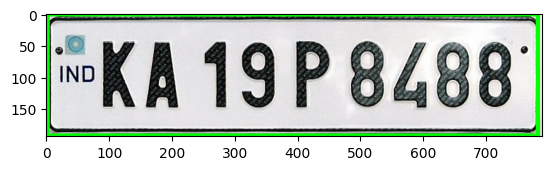

In [38]:
ANPR_new('Number plate2.jpg')

# PyTessearct

In [26]:
def crop_images_by_ids(frame, resultsTracker):
    cropped_images = {}  
    for result in resultsTracker:
        x1, y1, x2, y2, id = result
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

       
        cropped_image = frame[y1:y2, x1:x2]
        cropped_images[id] = cropped_image
        cv2.imwrite('ouput.jpg', cropped_image)
        text = pytesseract.image_to_string(cropped_image)
        alphanumeric_text = ''.join(filter(str.isalnum, text))
        
    return alphanumeric_text


# EasyOCR

In [8]:
def crop_images_by_ids(frame, resultsTracker):
    cropped_texts = {} 
    
    reader = easyocr.Reader(['en']) 
    for result in resultsTracker:
        x1, y1, x2, y2, id = result
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        cropped_image = frame[y1:y2, x1:x2]
        
        results = reader.readtext(cropped_image)

        detected_text = "" 

        for (bbox, text, prob) in results:
            detected_text += text + " " 

        cropped_texts[id] = detected_text

    return cropped_texts

# EasyOCR

In [30]:
import cv2
import numpy as np
from sort import Sort 
import cvzone
import math

cap = cv2.VideoCapture(0)

tracker = Sort(max_age=20, min_hits=3, iou_threshold=0.3)
totalCount = []


while True:
    ret, frame = cap.read()
    detections = np.empty((0, 5))
    
    results = model(frame)  # Assuming 'model' is your object detection model

    for r in results:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1,y1,x2,y2 = int(x1), int(y1), int(x2), int(y2)
            conf = math.ceil((box.conf[0] * 100)) / 100
            cls = int(box.cls[0])

            number_plate = ANPR_new(frame, x1, y1, x2, y2)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 5)
            cvzone.putTextRect(frame, f'{number_plate}', (max(40, x1), max(45, y1)), thickness=2, scale=2)

            currentArray = np.array([x1, y1, x2, y2, conf])
            detections = np.vstack((detections, currentArray))

    resultsTracker = tracker.update(detections)

    for result in resultsTracker:
        x1, y1, x2, y2, id = result.astype(int)

        w, h = x2 - x1, y2 - y1
    

    try:
        cv2.imshow('Sample video', frame)
    except:
        pass

    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



0: 480x640 (no detections), 77.5ms
Speed: 7.0ms preprocess, 77.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 45.7ms
Speed: 2.1ms preprocess, 45.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 46.3ms
Speed: 2.0ms preprocess, 46.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 45.9ms
Speed: 1.5ms preprocess, 45.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 41.0ms
Speed: 2.6ms preprocess, 41.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 39.1ms
Speed: 1.5ms preprocess, 39.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 35.9ms
Speed: 2.2ms preprocess, 35.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 28.2ms
Speed: 0.0ms preprocess, 28.2ms i

# PyTesseract

In [27]:
import cv2
import numpy as np
from sort import Sort 
import cvzone
import math

cap = cv2.VideoCapture('College.mp4')

tracker = Sort(max_age=20, min_hits=3, iou_threshold=0.3)
totalCount = []

def save_cropped_image_by_id(frame, id, x1, y1, x2, y2):
    cropped_image = frame[y1:y2, x1:x2]
    image_filename = f'id_{int(id)}.jpg'
    cv2.imwrite(image_filename, cropped_image)
    return cropped_image

while True:
    ret, frame = cap.read()
    detections = np.empty((0, 5))
    
    results = model(frame)  
    for r in results:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1,y1,x2,y2 = int(x1), int(y1), int(x2), int(y2)
            conf = math.ceil((box.conf[0] * 100)) / 100
            cls = int(box.cls[0])

            number_plate = img_to_text(frame, x1, y1, x2, y2)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 5)
            cvzone.putTextRect(frame, f'{number_plate}', (max(40, x1), max(45, y1)), thickness=2, scale=2)

            currentArray = np.array([x1, y1, x2, y2, conf])
            detections = np.vstack((detections, currentArray))

    resultsTracker = tracker.update(detections)

    for result in resultsTracker:
        x1, y1, x2, y2, id = result.astype(int)

        w, h = x2 - x1, y2 - y1

        if id not in totalCount:
            totalCount.append(id)
            cropped_image = save_cropped_image_by_id(frame, id, x1, y1, x2, y2)

           
    try:
        cv2.imshow('Sample video', frame)
    except:
        pass

    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



0: 384x640 2 number plates, 299.1ms
Speed: 6.0ms preprocess, 299.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 number plates, 36.9ms
Speed: 2.0ms preprocess, 36.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 number plates, 36.5ms
Speed: 3.9ms preprocess, 36.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 number plates, 29.0ms
Speed: 1.5ms preprocess, 29.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 number plates, 37.2ms
Speed: 15.9ms preprocess, 37.2ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 number plates, 37.0ms
Speed: 6.9ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 number plates, 27.1ms
Speed: 3.5ms preprocess, 27.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 number plates, 75.5ms
Speed: 13.1ms preprocess, 75.5